In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Twitter15-RNR"
unique_name = "RoBERTa_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Twitter15-RNR_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(1490, 768)

In [3]:
data = pd.read_csv("../../data/processed/twitter15_dataset_with_tvt.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,tvt,cv_fold,tt,tvt2,tvt2_1,tvt2_2,tvt2_3
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,training,1,training,training,validation,training,training
1,714598641827246081,an open letter to trump voters from his top st...,unverified,training,1,test,training,testting,training,training
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor,training,2,training,validation,validation,validation,testting
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,training,1,training,testting,testting,training,training
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,training,3,training,validation,training,validation,training


In [4]:
labels_str = ['rumour', 'non-rumour']
labels_str

['rumour', 'non-rumour']

In [5]:
labels = []
for i, d in data.iterrows():
#     lab = labels_str.index(d['label'])
    if d['label'] in ['true', 'false', 'unverified']:
        lab = 0
    else:
        lab = 1
    labels.append(lab)
labels[:10]

[0, 0, 1, 1, 0, 1, 0, 0, 0, 0]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(1024, 768)
(338, 768)
(128, 768)
(1024,)
(338,)
(128,)


In [8]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(1362, 768)


In [9]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(1362,)


In [10]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(128),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets=inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
            
            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss/len(trainloader))
            

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()
            
                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss/len(testloader))
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
            # if saves and test_loss < best_loss:
            #     print(f"Saving after new best loss : {test_loss}")
            #     best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break
            
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_4LayerNet_L2Reg_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_4LayerNet_L2Reg_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [11]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

Multiclass Classification using 4-Layer Linear Network Cross Validation
--- FOLD 1 ----
Using cuda
Saving after new best accuracy : 98.16849816849818
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 96.23507805325987, Validation Accuracy : 100.0, Train Loss : 0.37446970865130424, Validation Loss : 0.022763904184103012
-- Epoch 100, Train_Accuracy : 97.88797061524335, Validation Accuracy : 99.63369963369964, Train Loss : 0.22236922942101955, Validation Loss : 0.014545559883117676
-- Epoch 150, Train_Accuracy : 98.62258953168045, Validation Accuracy : 99.63369963369964, Train Loss : 0.13011161237955093, Validation Loss : 0.009545781649649143
-- Epoch 200, Train_Accuracy : 98.71441689623508, Validation Accuracy : 99.63369963369964, Train Loss : 0.1383857959881425, Validation Loss : 0.015766317024827003
-- Epoch 250, Train_Accuracy : 99.35720844811753, Validation Accuracy : 98.9010989010989, Train Loss : 0.07641443330794573, Validation Loss : 0.053191233426332474
-- Epo

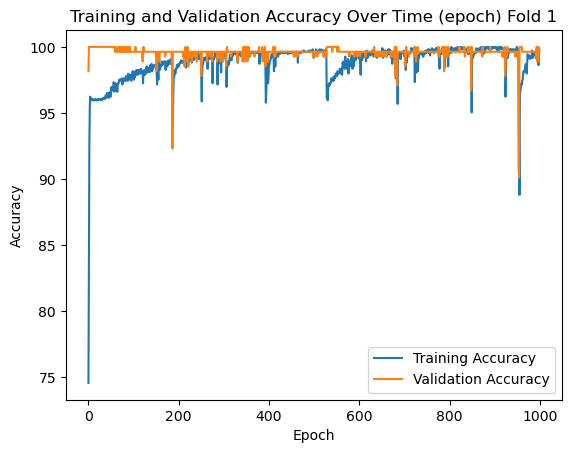

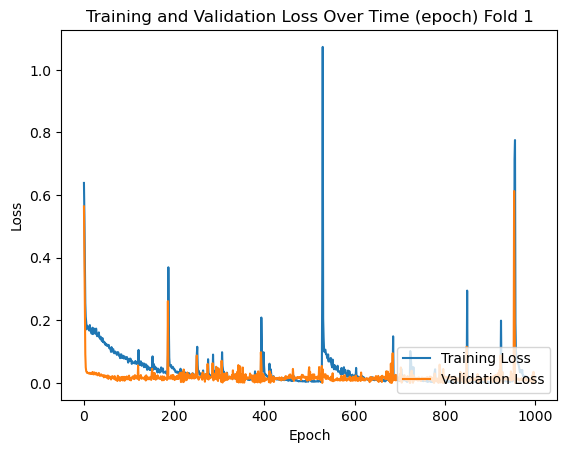

Exec Time : 24.92 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1.pth...

Train Set
Predictions : torch.Size([1089])
Binary Class Evaluation

True Positive : 240
False Positive : 11
False Negative : 34
True Negative : 804

Class non-rumour Evaluation
- Precision : 95.618 %
- Recall : 87.591 %
- F1 : 0.91429

Class rumour Evaluation
- Precision : 95.943 %
- Recall : 98.65 %
- F1 : 0.97278

Combined Evaluation
- Accuracy : 95.868 %
- Precision : 95.78 %
- Recall : 93.121 %
- F1 : 0.94432
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Train, 95.868, 95.78, 93.121, 0.94432, 95.618, 87.591, 0.91429, 95.943, 98.65, 0.97278, 
Confusion Matrix Scikit-learn: 
[[804  11]
 [ 34 240]]


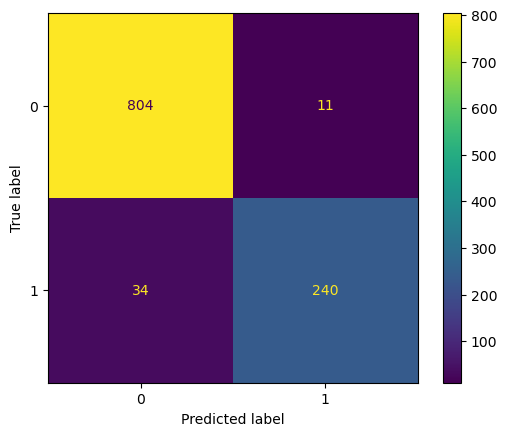


Validation Set
Predictions : torch.Size([273])
Binary Class Evaluation

True Positive : 69
False Positive : 0
False Negative : 0
True Negative : 204

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[204   0]
 [  0  69]]


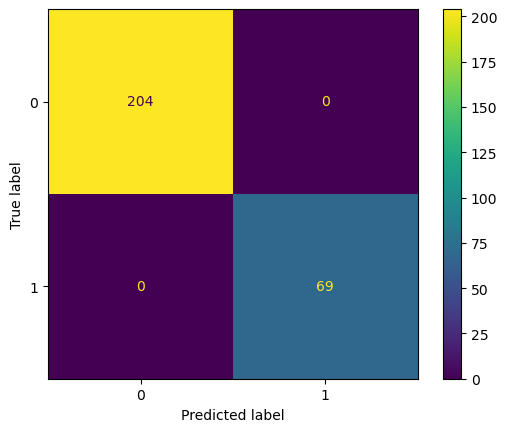


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 22
False Positive : 5
False Negative : 9
True Negative : 92

Class non-rumour Evaluation
- Precision : 81.481 %
- Recall : 70.968 %
- F1 : 0.75862

Class rumour Evaluation
- Precision : 91.089 %
- Recall : 94.845 %
- F1 : 0.92929

Combined Evaluation
- Accuracy : 89.062 %
- Precision : 86.285 %
- Recall : 82.907 %
- F1 : 0.84562
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Test, 89.062, 86.285, 82.907, 0.84562, 81.481, 70.968, 0.75862, 91.089, 94.845, 0.92929, 
128
128
Confusion Matrix Scikit-learn: 
[[92  5]
 [ 9 22]]


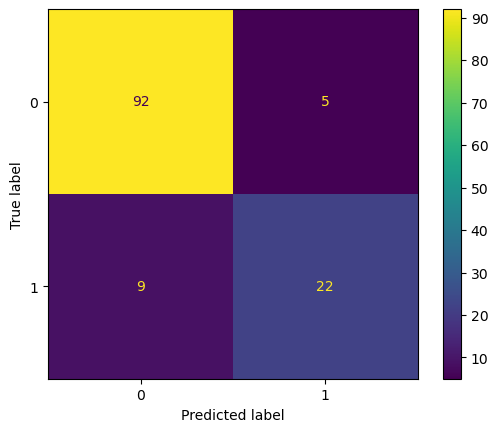

--- FOLD 2 ----
Using cuda
Saving after new best accuracy : 74.72527472527473
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 96.41873278236915, Validation Accuracy : 100.0, Train Loss : 0.37064743787050247, Validation Loss : 0.02181783877313137
-- Epoch 100, Train_Accuracy : 97.88797061524335, Validation Accuracy : 99.26739926739927, Train Loss : 0.24435543455183506, Validation Loss : 0.028541285544633865
-- Epoch 150, Train_Accuracy : 98.80624426078971, Validation Accuracy : 99.63369963369964, Train Loss : 0.11189641151577234, Validation Loss : 0.017482686787843704
-- Epoch 200, Train_Accuracy : 99.08172635445362, Validation Accuracy : 99.63369963369964, Train Loss : 0.0876701446250081, Validation Loss : 0.013695316389203072
-- Epoch 250, Train_Accuracy : 98.89807162534436, Validation Accuracy : 99.63369963369964, Train Loss : 0.08453953824937344, Validation Loss : 0.025080453604459763
-- Epoch 300, Train_Accuracy : 99.17355371900827, Validation Accuracy : 97.435

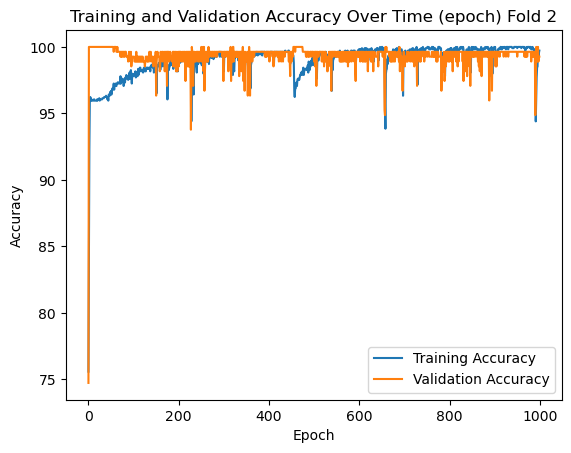

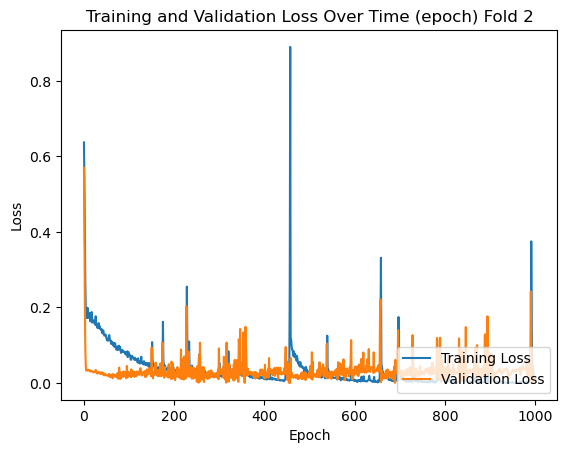

Exec Time : 24.06 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2.pth...

Train Set
Predictions : torch.Size([1089])
Binary Class Evaluation

True Positive : 241
False Positive : 11
False Negative : 33
True Negative : 804

Class non-rumour Evaluation
- Precision : 95.635 %
- Recall : 87.956 %
- F1 : 0.91635

Class rumour Evaluation
- Precision : 96.057 %
- Recall : 98.65 %
- F1 : 0.97337

Combined Evaluation
- Accuracy : 95.96 %
- Precision : 95.846 %
- Recall : 93.303 %
- F1 : 0.94557
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Train, 95.96, 95.846, 93.303, 0.94557, 95.635, 87.956, 0.91635, 96.057, 98.65, 0.97337, 
Confusion Matrix Scikit-learn: 
[[804  11]
 [ 33 241]]


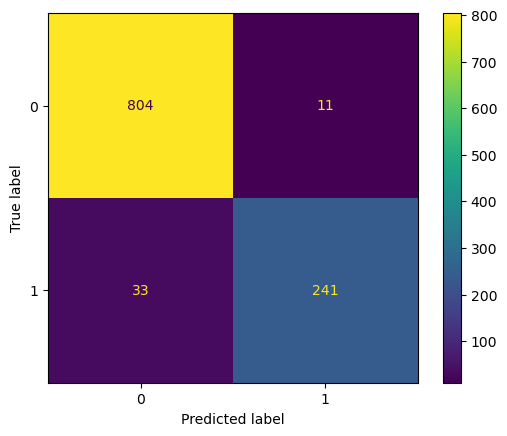


Validation Set
Predictions : torch.Size([273])
Binary Class Evaluation

True Positive : 69
False Positive : 0
False Negative : 0
True Negative : 204

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[204   0]
 [  0  69]]


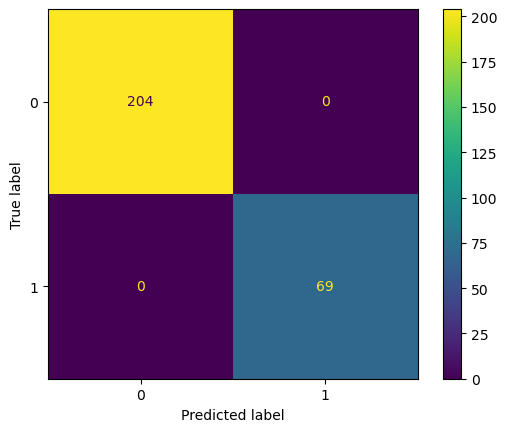


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 22
False Positive : 5
False Negative : 9
True Negative : 92

Class non-rumour Evaluation
- Precision : 81.481 %
- Recall : 70.968 %
- F1 : 0.75862

Class rumour Evaluation
- Precision : 91.089 %
- Recall : 94.845 %
- F1 : 0.92929

Combined Evaluation
- Accuracy : 89.062 %
- Precision : 86.285 %
- Recall : 82.907 %
- F1 : 0.84562
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Test, 89.062, 86.285, 82.907, 0.84562, 81.481, 70.968, 0.75862, 91.089, 94.845, 0.92929, 
128
128
Confusion Matrix Scikit-learn: 
[[92  5]
 [ 9 22]]


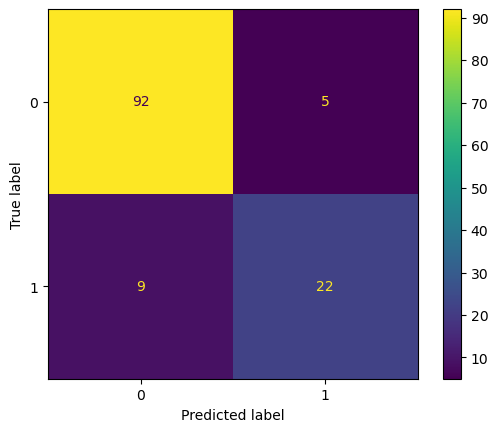

--- FOLD 3 ----
Using cuda
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 96.42201834862385, Validation Accuracy : 100.0, Train Loss : 0.4028595369309187, Validation Loss : 0.02127073146402836
-- Epoch 100, Train_Accuracy : 98.1651376146789, Validation Accuracy : 100.0, Train Loss : 0.22968992963433266, Validation Loss : 0.008854835294187069
-- Epoch 150, Train_Accuracy : 98.53211009174312, Validation Accuracy : 98.8970588235294, Train Loss : 0.14624054729938507, Validation Loss : 0.02307642623782158
-- Epoch 200, Train_Accuracy : 98.34862385321101, Validation Accuracy : 100.0, Train Loss : 0.17130434326827526, Validation Loss : 0.015270699746906757
-- Epoch 250, Train_Accuracy : 99.1743119266055, Validation Accuracy : 97.05882352941177, Train Loss : 0.0814964547753334, Validation Loss : 0.09923042356967926
-- Epoch 300, Train_Accuracy : 98.07339449541284, Validation Accuracy : 98.52941176470588, Train Loss : 0.20798312680562958, Validation Loss : 0.06215158477425

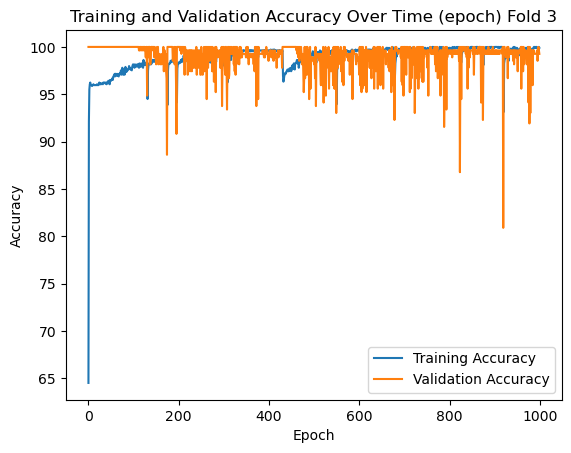

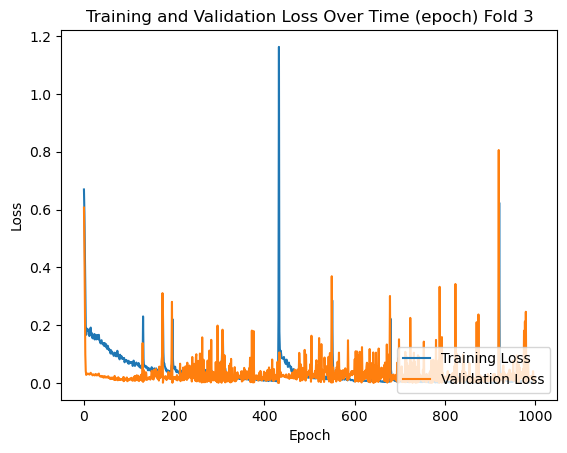

Exec Time : 24.43 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3.pth...

Train Set
Predictions : torch.Size([1090])
Binary Class Evaluation

True Positive : 242
False Positive : 11
False Negative : 33
True Negative : 804

Class non-rumour Evaluation
- Precision : 95.652 %
- Recall : 88.0 %
- F1 : 0.91667

Class rumour Evaluation
- Precision : 96.057 %
- Recall : 98.65 %
- F1 : 0.97337

Combined Evaluation
- Accuracy : 95.963 %
- Precision : 95.855 %
- Recall : 93.325 %
- F1 : 0.94573
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Train, 95.963, 95.855, 93.325, 0.94573, 95.652, 88.0, 0.91667, 96.057, 98.65, 0.97337, 
Confusion Matrix Scikit-learn: 
[[804  11]
 [ 33 242]]


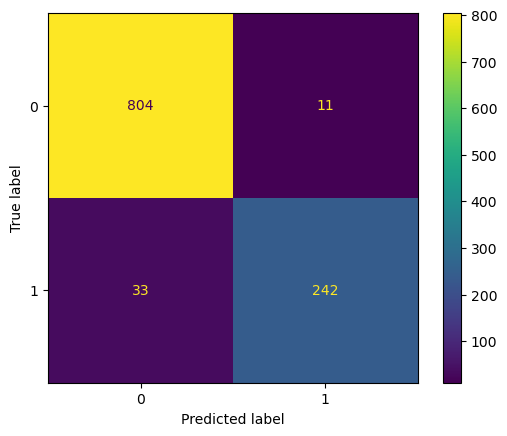


Validation Set
Predictions : torch.Size([272])
Binary Class Evaluation

True Positive : 68
False Positive : 0
False Negative : 0
True Negative : 204

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[204   0]
 [  0  68]]


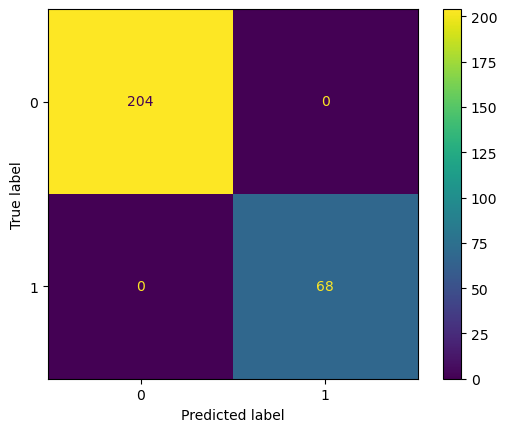


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 22
False Positive : 5
False Negative : 9
True Negative : 92

Class non-rumour Evaluation
- Precision : 81.481 %
- Recall : 70.968 %
- F1 : 0.75862

Class rumour Evaluation
- Precision : 91.089 %
- Recall : 94.845 %
- F1 : 0.92929

Combined Evaluation
- Accuracy : 89.062 %
- Precision : 86.285 %
- Recall : 82.907 %
- F1 : 0.84562
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Test, 89.062, 86.285, 82.907, 0.84562, 81.481, 70.968, 0.75862, 91.089, 94.845, 0.92929, 
128
128
Confusion Matrix Scikit-learn: 
[[92  5]
 [ 9 22]]


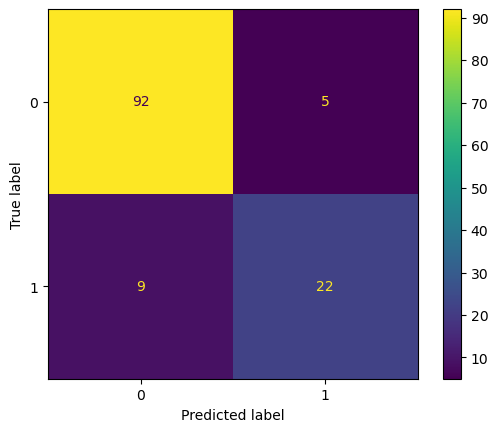

--- FOLD 4 ----
Using cuda
Saving after new best accuracy : 97.05882352941177
Saving after new best accuracy : 97.42647058823529
Saving after new best accuracy : 97.79411764705883
-- Epoch 50, Train_Accuracy : 96.78899082568807, Validation Accuracy : 97.42647058823529, Train Loss : 0.303779523819685, Validation Loss : 0.08747994899749756
-- Epoch 100, Train_Accuracy : 98.34862385321101, Validation Accuracy : 97.05882352941177, Train Loss : 0.1789842303842306, Validation Loss : 0.12394192814826965
-- Epoch 150, Train_Accuracy : 98.71559633027523, Validation Accuracy : 96.69117647058823, Train Loss : 0.12914371956139803, Validation Loss : 0.1578381508588791
-- Epoch 200, Train_Accuracy : 99.26605504587155, Validation Accuracy : 95.58823529411765, Train Loss : 0.07600478990934789, Validation Loss : 0.204287588596344
-- Epoch 250, Train_Accuracy : 99.44954128440367, Validation Accuracy : 95.58823529411765, Train Loss : 0.058385154232382774, Validation Loss : 0.24868154525756836
-- Epoch 30

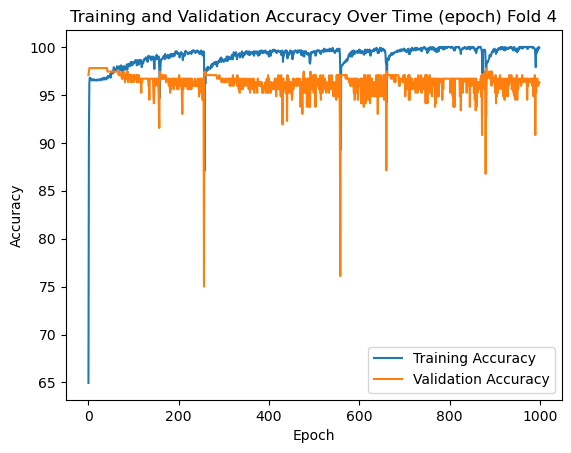

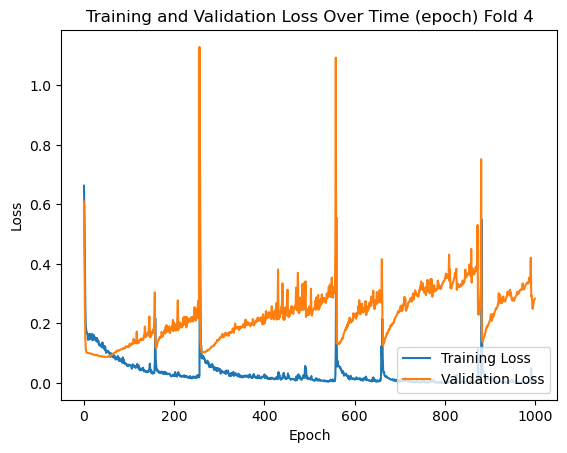

Exec Time : 24.71 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4.pth...

Train Set
Predictions : torch.Size([1090])
Binary Class Evaluation

True Positive : 251
False Positive : 11
False Negative : 24
True Negative : 804

Class non-rumour Evaluation
- Precision : 95.802 %
- Recall : 91.273 %
- F1 : 0.93482

Class rumour Evaluation
- Precision : 97.101 %
- Recall : 98.65 %
- F1 : 0.9787

Combined Evaluation
- Accuracy : 96.789 %
- Precision : 96.451 %
- Recall : 94.962 %
- F1 : 0.95701
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Train, 96.789, 96.451, 94.962, 0.95701, 95.802, 91.273, 0.93482, 97.101, 98.65, 0.9787, 
Confusion Matrix Scikit-learn: 
[[804  11]
 [ 24 251]]


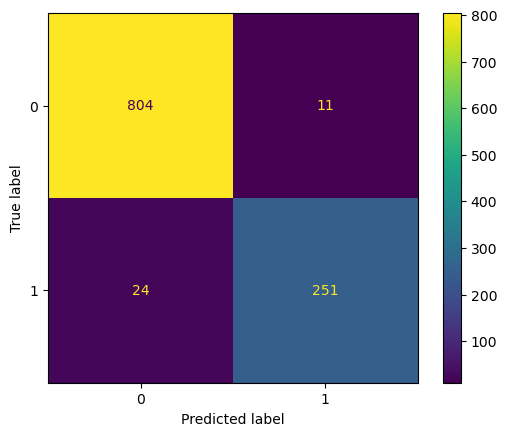


Validation Set
Predictions : torch.Size([272])
Binary Class Evaluation

True Positive : 63
False Positive : 1
False Negative : 5
True Negative : 203

Class non-rumour Evaluation
- Precision : 98.438 %
- Recall : 92.647 %
- F1 : 0.95455

Class rumour Evaluation
- Precision : 97.596 %
- Recall : 99.51 %
- F1 : 0.98544

Combined Evaluation
- Accuracy : 97.794 %
- Precision : 98.017 %
- Recall : 96.078 %
- F1 : 0.97038
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Validation, 97.794, 98.017, 96.078, 0.97038, 98.438, 92.647, 0.95455, 97.596, 99.51, 0.98544, 
Confusion Matrix Scikit-learn: 
[[203   1]
 [  5  63]]


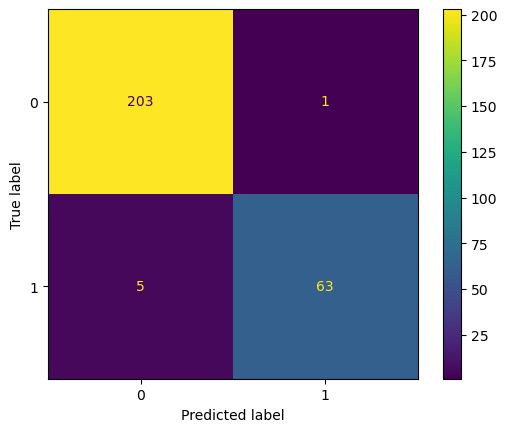


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 22
False Positive : 5
False Negative : 9
True Negative : 92

Class non-rumour Evaluation
- Precision : 81.481 %
- Recall : 70.968 %
- F1 : 0.75862

Class rumour Evaluation
- Precision : 91.089 %
- Recall : 94.845 %
- F1 : 0.92929

Combined Evaluation
- Accuracy : 89.062 %
- Precision : 86.285 %
- Recall : 82.907 %
- F1 : 0.84562
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Test, 89.062, 86.285, 82.907, 0.84562, 81.481, 70.968, 0.75862, 91.089, 94.845, 0.92929, 
128
128
Confusion Matrix Scikit-learn: 
[[92  5]
 [ 9 22]]


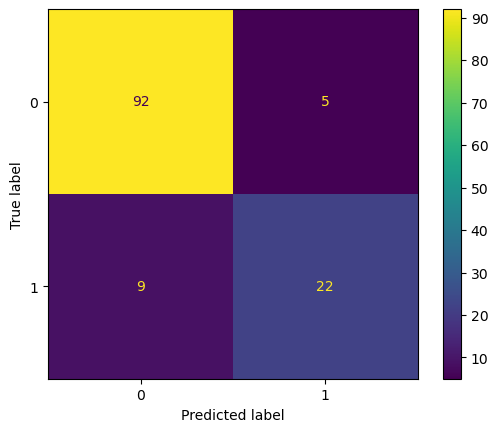

--- FOLD 5 ----
Using cuda
Saving after new best accuracy : 86.3970588235294
Saving after new best accuracy : 87.13235294117646
-- Epoch 50, Train_Accuracy : 99.54128440366972, Validation Accuracy : 85.66176470588235, Train Loss : 0.18141459207981825, Validation Loss : 0.5765061378479004
-- Epoch 100, Train_Accuracy : 99.90825688073394, Validation Accuracy : 86.02941176470588, Train Loss : 0.01082446938380599, Validation Loss : 1.212565541267395
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 84.19117647058823, Train Loss : 0.009620896831620485, Validation Loss : 1.3106377124786377
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 85.66176470588235, Train Loss : 0.0009870221620076336, Validation Loss : 1.687834620475769
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 84.19117647058823, Train Loss : 0.017953707472770475, Validation Loss : 1.1502840518951416
-- Epoch 300, Train_Accuracy : 100.0, Validation Accuracy : 84.55882352941177, Train Loss : 0.001

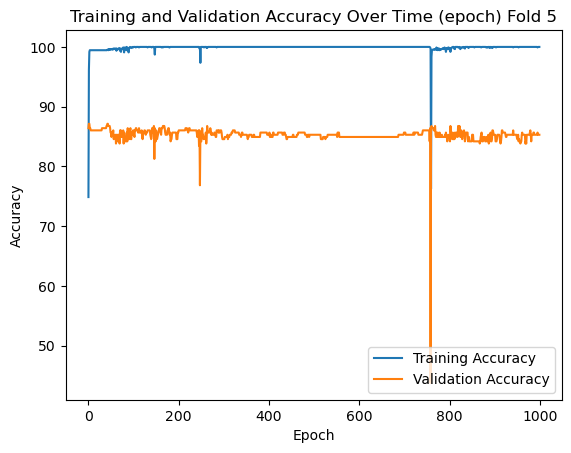

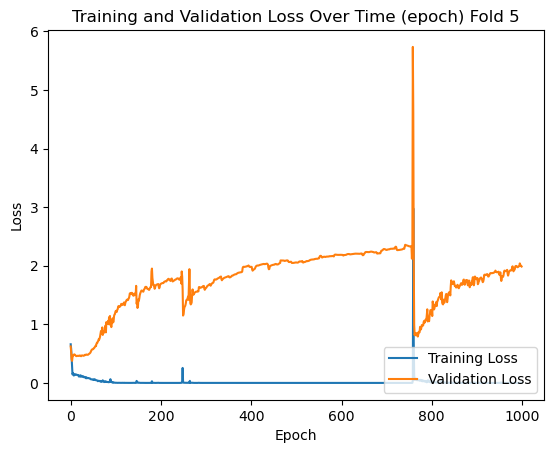

Exec Time : 24.96 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5.pth...

Train Set
Predictions : torch.Size([1090])
Binary Class Evaluation

True Positive : 269
False Positive : 1
False Negative : 5
True Negative : 815

Class non-rumour Evaluation
- Precision : 99.63 %
- Recall : 98.175 %
- F1 : 0.98897

Class rumour Evaluation
- Precision : 99.39 %
- Recall : 99.877 %
- F1 : 0.99633

Combined Evaluation
- Accuracy : 99.45 %
- Precision : 99.51 %
- Recall : 99.026 %
- F1 : 0.99267
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Train, 99.45, 99.51, 99.026, 0.99267, 99.63, 98.175, 0.98897, 99.39, 99.877, 0.99633, 
Confusion Matrix Scikit-learn: 
[[815   1]
 [  5 269]]


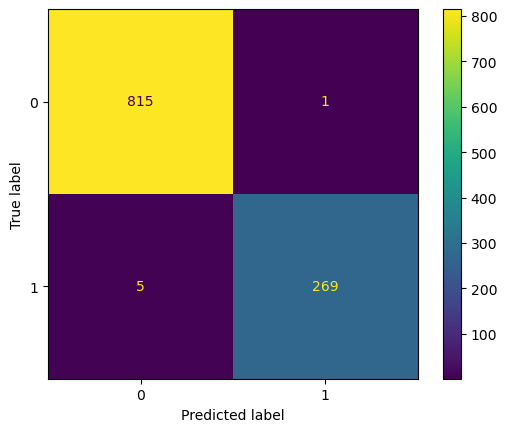


Validation Set
Predictions : torch.Size([272])
Binary Class Evaluation

True Positive : 45
False Positive : 11
False Negative : 24
True Negative : 192

Class non-rumour Evaluation
- Precision : 80.357 %
- Recall : 65.217 %
- F1 : 0.72

Class rumour Evaluation
- Precision : 88.889 %
- Recall : 94.581 %
- F1 : 0.91647

Combined Evaluation
- Accuracy : 87.132 %
- Precision : 84.623 %
- Recall : 79.899 %
- F1 : 0.82193
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Validation, 87.132, 84.623, 79.899, 0.82193, 80.357, 65.217, 0.72, 88.889, 94.581, 0.91647, 
Confusion Matrix Scikit-learn: 
[[192  11]
 [ 24  45]]


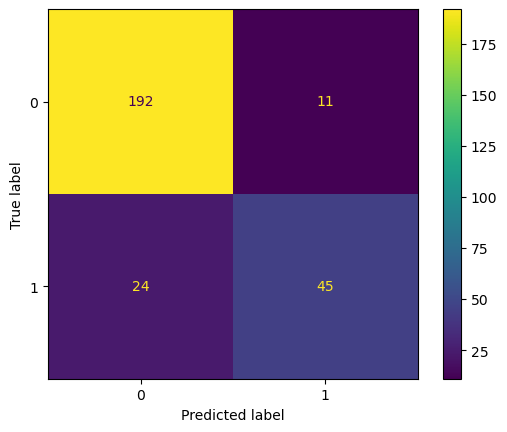


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 22
False Positive : 5
False Negative : 9
True Negative : 92

Class non-rumour Evaluation
- Precision : 81.481 %
- Recall : 70.968 %
- F1 : 0.75862

Class rumour Evaluation
- Precision : 91.089 %
- Recall : 94.845 %
- F1 : 0.92929

Combined Evaluation
- Accuracy : 89.062 %
- Precision : 86.285 %
- Recall : 82.907 %
- F1 : 0.84562
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Test, 89.062, 86.285, 82.907, 0.84562, 81.481, 70.968, 0.75862, 91.089, 94.845, 0.92929, 
128
128
Confusion Matrix Scikit-learn: 
[[92  5]
 [ 9 22]]


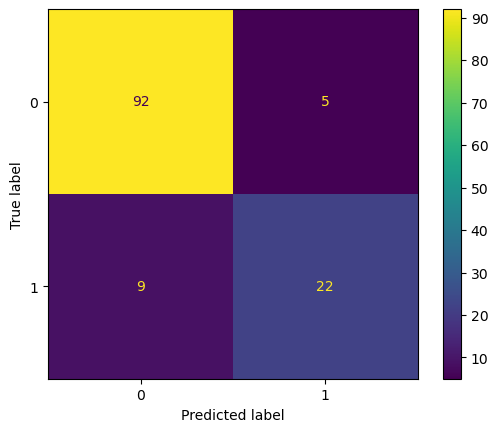

In [12]:
print("Multiclass Classification using 4-Layer Linear Network Cross Validation")

for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
       
    start = time.time()
    model_name = f"{dataset_name}_4LayerNet_L2Reg_{unique_name}_Fold{i+1}"
    model = NNClassifier(train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
    model.train_eval(torch.Tensor(train_vectors),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\nTrain Set")
    preds = model.predict(train_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nValidation Set")
    preds = model.predict(val_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nTest Set")
    preds = model.predict(test_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()